In [1]:
import zarr
import dask_image.ndfilters
import dask.array as da
import matplotlib.pyplot as plt

When working with Dask on a single node, you should request many CPUs and much RAM. In some cases, you may want to grab an entire node. 

1) Open a slidescan saved as an OME-zarr over https

In [2]:
za = zarr.open('http://s3-far.jax.org/zarrtest/histopath_example.zarr/0/0', mode='r')
za.info

Type,zarr.core.Array
Data type,uint8
Shape,"(1, 3, 1, 48896, 109440)"
Chunk shape,"(1, 1, 1, 4096, 4096)"
Order,C
Read-only,True
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.FSStore
No. bytes,16053534720 (15.0G)
Chunks initialized,0/972


2) Load the dask array from zarr. _Note that this will not actually request any data yet_

In [3]:
d = da.from_zarr(za, chunks=(1,3,1,4096*4, 4096*4))
d

dask.array<from-zarr, shape=(1, 3, 1, 48896, 109440), dtype=uint8, chunksize=(1, 3, 1, 16384, 16384), chunktype=numpy.ndarray>

3) Operations like axis reordering can be performed on the dask array without doing any processing, including requesting the source data

In [4]:
d = da.moveaxis(d, 1, -1)
d = da.squeeze(d)
d

dask.array<getitem, shape=(48896, 109440, 3), dtype=uint8, chunksize=(16384, 16384, 3), chunktype=numpy.ndarray>

4. It is only when we try to do something with the array, like visualize as an image, that the array data are loaded from object storage

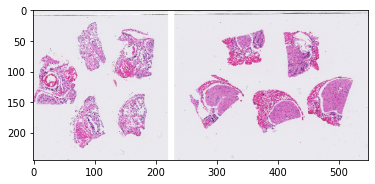

In [5]:
plt.imshow(d[::200, ::200, :]); # Note the downsampling

5. Even though the operation above loaded the image data from object storage, those data were not held in memory. Subsequent operations will reload from object storage

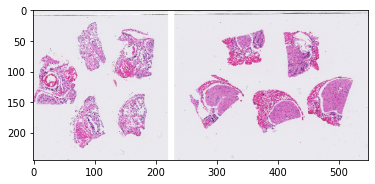

In [6]:
plt.imshow(d[::200, ::200, :]); # This should take about the same amount of time as the previous line

6. You can use `persist()` to load an array and keep it in memory

In [7]:
d = d.persist()
d

dask.array<getitem, shape=(48896, 109440, 3), dtype=uint8, chunksize=(16384, 16384, 3), chunktype=numpy.ndarray>

7. Now operations like visualization will be quite fast

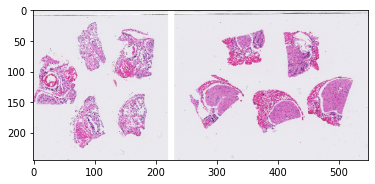

In [8]:
plt.imshow(d[::200, ::200, :]); #This should take no time at all

8. It can be a good idea to cache intermediate results with persist to minimize downstream computations. Here we first compute a grayscale version of our source array

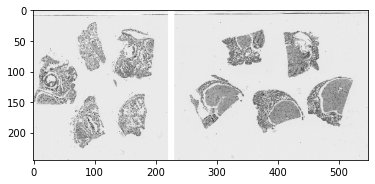

In [9]:
grayd = (d[:,:,0] * 0.299) + (d[:,:,1] * 0.587) + (d[:,:,2] * 0.114)
grayd = grayd.persist()
plt.imshow(grayd[::200, ::200], cmap='gray');

9. Note that the grayscale conversion changed the array type

In [10]:
grayd # This is now `float64`, i.e., larger memory footprint

dask.array<add, shape=(48896, 109440), dtype=float64, chunksize=(16384, 16384), chunktype=numpy.ndarray>

10. When working with dask arrays, remember that no computations are performed until you ask for a result

In [11]:
grayd.max()

dask.array<amax-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

In [12]:
grayd.max().compute()

255.0

11. You can visualize how computations are perfomed, but this can be hard to look at for large arrays with many chunks

In [13]:
grayd.std().compute()

37.7127762191658

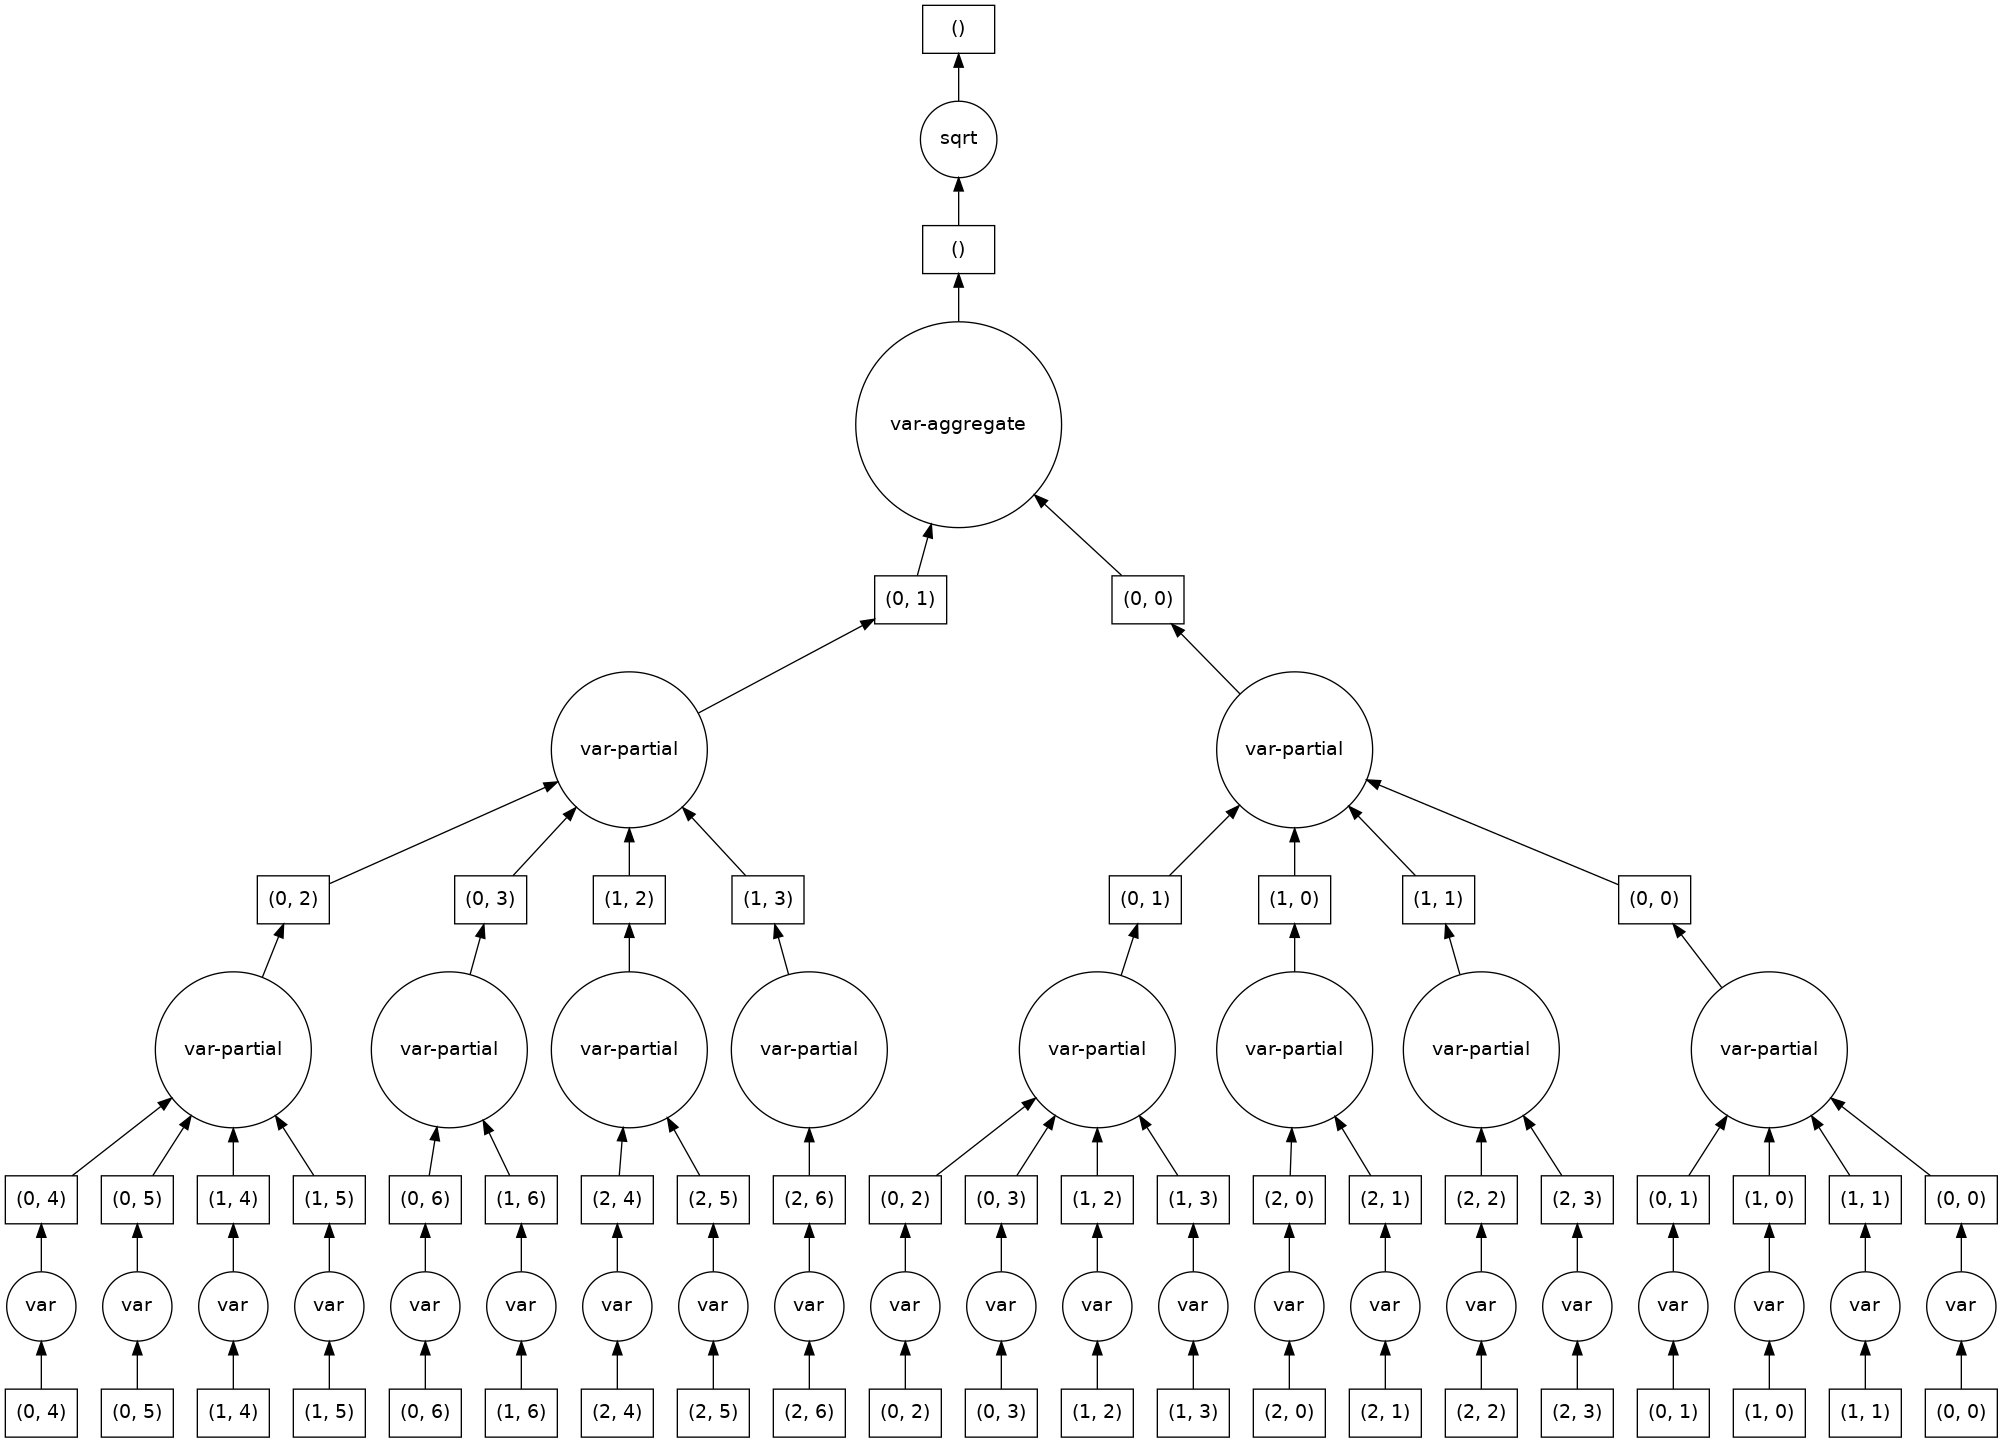

In [14]:
grayd.std().visualize()

12. Dask will only perform computations where they are needed if slicing is used. This improves efficiency

In [15]:
grayd[:1000, :1000].std().compute()

1.6538022836823343

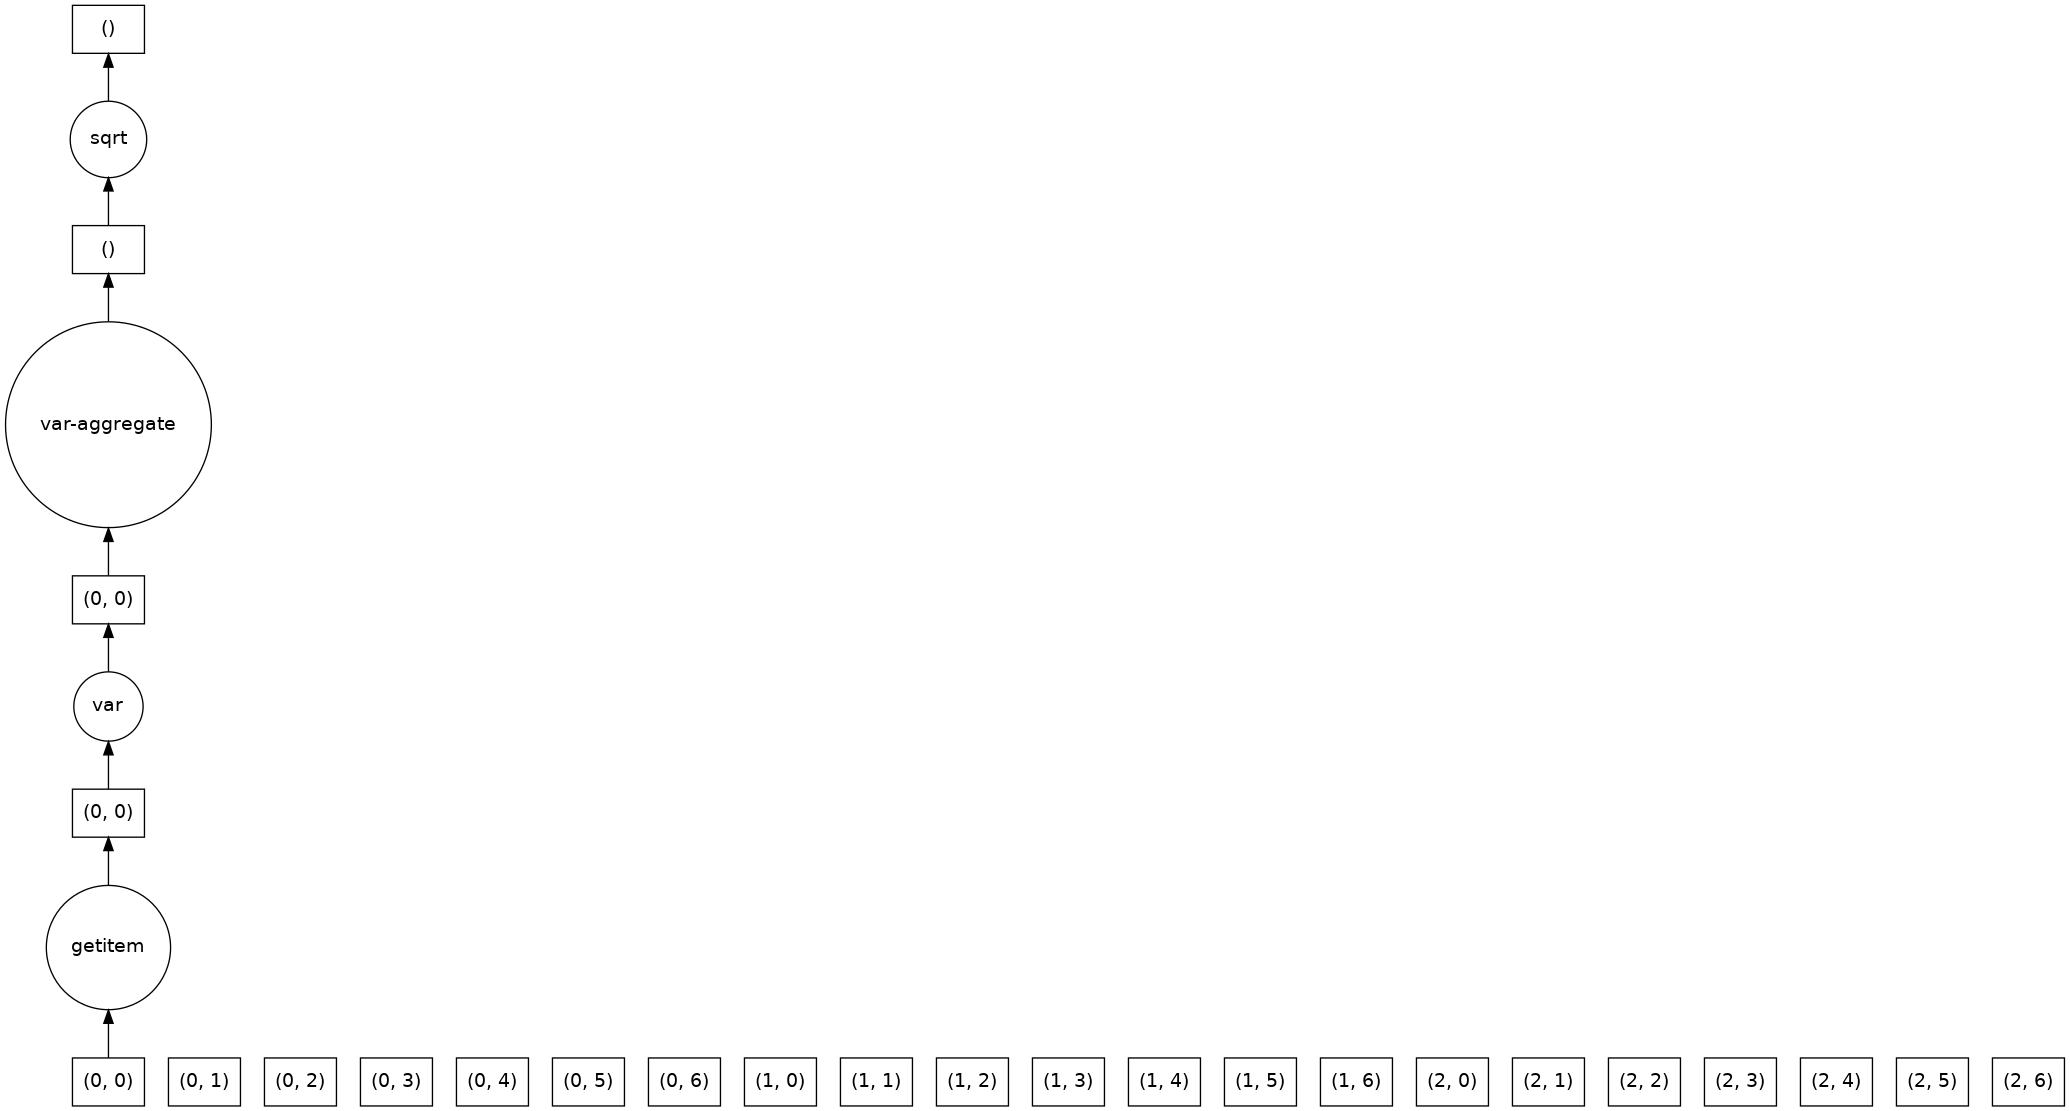

In [16]:
grayd[:1000, :1000].std().visualize()

13. dask_image has some useful tools for image analysis using dask

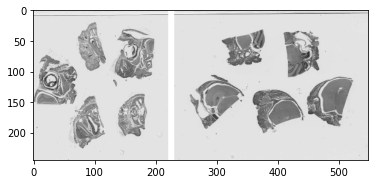

In [22]:
filtered50 = dask_image.ndfilters.gaussian_filter(grayd, 50)
plt.imshow(filtered50[::200, ::200], cmap='gray'); # This will take a minute

14. remember to cache results if you want to do multiple things with the same intermediate array. Just watch your memory utilization!

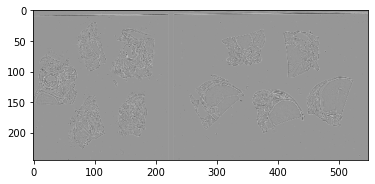

In [23]:
dog_grayd = dask_image.ndfilters.gaussian_filter(grayd, 50) - dask_image.ndfilters.gaussian_filter(grayd, 75)
dog_grayd = dog_grayd.persist() # This will take a minute
plt.imshow(dog_grayd[::200, ::200], cmap='gray');

15. Since we cached `dog_grayd`, we can quickly look around at different slices in full resolution

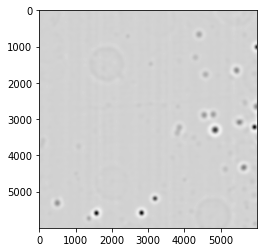

In [24]:
plt.imshow(dog_grayd[8000:14000, 8000:14000], cmap='gray');

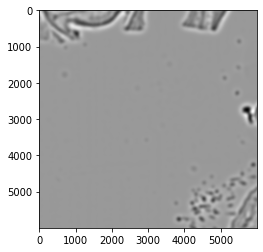

In [25]:
plt.imshow(dog_grayd[30000:36000, 8000:14000], cmap='gray');

16. Of course downsampling can make visualization even faster, at the expense of some detail

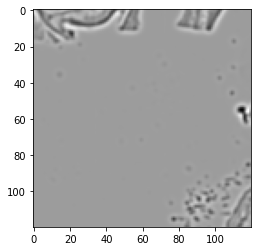

In [26]:
plt.imshow(dog_grayd[30000:36000:50, 8000:14000:50], cmap='gray');